In [1]:
import numpy as np
print(np)
%matplotlib nbagg
import matplotlib
from scipy import special
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt
from eigentools import Eigenproblem

<module 'numpy' from '/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/__init__.py'>


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:

R1 = 1
R2 = 3
Omega1 = 1
Omega2 = 0.12087
beta = 41.2
xi=0
norm = True
Pm = 1.6E-4
Rm = 3.33105476634
Q = 0.90498707034113368

#Pm = 1.60000000e-06
#Rm = 3.30
#Q = 0.901
conducting=True

# Goodman & Ji 2002 parameters
"""
Rm =3.32
Q = 0.840
R1 = 1
R2 = 3
Omega1 = 1
Omega2 = 0.12087
beta = 41.2
Pm = 1.6e-6
xi=0
conducting = True
"""

# Hollerbach & Rudiger parameters
"""
R1=1 
R2=2
Omega1 = 1.0 # nondimensionalized by inner cylinder values
Omega2 = 0.27
Pm=1.0E-6 
beta=0.0174 
xi=4.0 
Q = 2.33
Rm = 0.001521
conducting = False
"""

Re = Rm/Pm
iRm = 1.0/Rm
iR = 1.0/Re

c1 = (Omega2*R2**2 - Omega1*R1**2)/(R2**2 - R1**2)
c2 = (R1**2*R2**2*(Omega1 - Omega2))/(R2**2 - R1**2)

nr1 = 128
r_shortgrid = de.Chebyshev('r', nr1, interval=(R1, R2))
d1 = de.Domain([r_shortgrid])

In [3]:
lv1 = de.EVP(d1,
         ['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

lv1.parameters['Q'] = Q
lv1.parameters['iR'] = iR
lv1.parameters['iRm'] = iRm
lv1.parameters['xi'] = xi
lv1.parameters['beta'] = beta
lv1.parameters['c1'] = c1
lv1.parameters['c2'] = c2
lv1.parameters['B0'] = 1

if conducting is False:
    lv1.parameters['bessel1'] = special.iv(0, Q*R1)/special.iv(1, Q*R1)
    lv1.parameters['bessel2'] = special.kn(0, Q*R2)/special.kn(1, Q*R2)

lv1.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
lv1.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
lv1.substitutions['twooverbeta'] = '(2.0/beta)'

lv1.substitutions['psivisc'] = '(2*r**2*Q**2*psir - 2*r**3*Q**2*psirr + r**3*Q**4*psi + r**3*dr(psirrr) - 3*psir + 3*r*psirr - 2*r**2*psirrr)'
lv1.substitutions['uvisc'] = '(-r**3*Q**2*u + r**3*dr(ur) + r**2*ur - r*u)'
lv1.substitutions['Avisc'] = '(r*dr(Ar) - r*Q**2*A - Ar)' 
lv1.substitutions['Bvisc'] = '(-r**3*Q**2*B + r**3*dr(Br) + r**2*Br - r*B)'

lv1.add_equation("sigma*(-r**3*Q**2*psi + r**3*psirr - r**2*psir) - r**2*2*ru0*1j*Q*u + r**3*twooverbeta*B0*1j*Q**3*A + twooverbeta*B0*r**2*1j*Q*Ar - twooverbeta*r**3*B0*1j*Q*dr(Ar) - iR*psivisc + twooverbeta*r**2*2*xi*1j*Q*B = 0") #corrected on whiteboard 5/6
lv1.add_equation("sigma*r**3*u + 1j*Q*ru0*psi + 1j*Q*rrdu0*psi - 1j*Q*r**3*twooverbeta*B0*B - iR*uvisc = 0") 
lv1.add_equation("sigma*r*A - r*B0*1j*Q*psi - iRm*Avisc = 0")
lv1.add_equation("sigma*r**3*B + ru0*1j*Q*A - r**3*B0*1j*Q*u - 1j*Q*rrdu0*A - iRm*Bvisc - 2*xi*1j*Q*psi = 0") 

lv1.add_equation("dr(psi) - psir = 0")
lv1.add_equation("dr(psir) - psirr = 0")
lv1.add_equation("dr(psirr) - psirrr = 0")
lv1.add_equation("dr(u) - ur = 0")
lv1.add_equation("dr(A) - Ar = 0")
lv1.add_equation("dr(B) - Br = 0")

lv1.add_bc('left(u) = 0')
lv1.add_bc('right(u) = 0')
lv1.add_bc('left(psi) = 0')
lv1.add_bc('right(psi) = 0')
lv1.add_bc('left(psir) = 0')
lv1.add_bc('right(psir) = 0')
if conducting is True:
    print("solving w/ conducting bc's")
    lv1.add_bc('left(A) = 0')
    lv1.add_bc('right(A) = 0')
    lv1.add_bc('left(B + r*Br) = 0')
    lv1.add_bc('right(B + r*Br) = 0')
# try w/ insulating bcs
else:
    #lv1.add_bc('left(dr(r*A) - Q*r*bessel1*A) = 0')
    #lv1.add_bc('right(dr(r*A) + Q*r*bessel2*A) = 0') # dz is just a constant so divide it out! (problematic for V20)
    lv1.add_bc('left(dr(A) - Q*bessel1*A) = 0')
    lv1.add_bc('right(dr(A) + Q*bessel2*A) = 0')
    lv1.add_bc('left(B) = 0')
    lv1.add_bc('right(B) = 0')

2016-08-18 17:27:14,546 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
solving w/ conducting bc's


In [4]:
#ordere = lv1.build_solver()
#ordere.solve(ordere.pencils[0])

#evals_ordere = ordere.eigenvalues
EPordere = Eigenproblem(lv1)
EPordere.solve()
EPordere.reject_spurious()
evals_ordere = EPordere.evalues_good


2016-08-18 17:29:07,828 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta
/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


In [ ]:
#fig = plt.figure()
#plt.plot(ev1.real, ev1adj.real, '.')

The following is the old adjoint, currently in allorders2_widegap

In [ ]:
"""
adjold = de.EVP(d1,
         ['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

adjold.parameters['Q'] = Q
adjold.parameters['iR'] = iR
adjold.parameters['iRm'] = iRm
adjold.parameters['xi'] = xi
adjold.parameters['beta'] = beta
adjold.parameters['c1'] = c1
adjold.parameters['c2'] = c2
adjold.parameters['B0'] = 1
adjold.parameters['dz'] = 1j*Q

adjold.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
adjold.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
adjold.substitutions['twooverbeta'] = '(2.0/beta)'

# multiply by [r^4, r^2, r^3, r^2]
adjold.add_equation("sigma*(-r**3*Q**2*psi + r**3*psirr - r**2*psir) - r*1j*Q*rrdu0*u - r*ru0*1j*Q*u + r**4*1j*Q*A - iR*r**3*Q**4*psi + iR*r**3*2*Q**2*psirr - iR*r**2*2*Q**2*psir - iR*r**3*dr(psirrr) + iR*r**2*2*psirrr - iR*r*3*psirr + iR*3*psir + r*2*1j*Q*B0*xi*B = 0")
adjold.add_equation("sigma*r**2*u + 1j*Q*r**2*B + 2*1j*Q*ru0*psi + iR*Q**2*r**2*u - iR*r**2*dr(ur) -iR*r*ur + iR*u = 0")
adjold.add_equation("sigma*r**3*A + rrdu0*1j*Q*B - ru0*1j*Q*B - twooverbeta*r**2*1j*Q**3*psi + twooverbeta*r**2*1j*Q*psirr - twooverbeta*r*1j*Q*psir + iRm*r**3*Q**2*A - iRm*r**3*dr(Ar) + iRm*r**2*Ar = 0")
adjold.add_equation("sigma*r**2*B + r**2*twooverbeta*1j*Q*u + r**2*iRm*Q**2*B - r**2*iRm*dr(Br) - iRm*r*Br + iRm*B - twooverbeta*2*1j*Q*B0*xi*psi = 0") 

adjold.add_equation("dr(psi) - psir = 0")
adjold.add_equation("dr(psir) - psirr = 0")
adjold.add_equation("dr(psirr) - psirrr = 0")
adjold.add_equation("dr(u) - ur = 0")
adjold.add_equation("dr(A) - Ar = 0")
adjold.add_equation("dr(B) - Br = 0")

adjold.add_bc('left(u) = 0')
adjold.add_bc('right(u) = 0')
adjold.add_bc('left(psi) = 0')
adjold.add_bc('right(psi) = 0')
adjold.add_bc('left(psir) = 0')
adjold.add_bc('right(psir) = 0')
adjold.add_bc('left(A) = 0')
adjold.add_bc('right(A) = 0')
#adjold.add_bc('left(B) = 0')
#adjold.add_bc('right(B) = 0')
adjold.add_bc('left(B + r*Br) = 0')
adjold.add_bc('right(B + r*Br) = 0') # axial component of current = 0

EPadjold = Eigenproblem(adjold)

#adjprob = adjold.build_solver()
#adjprob.solve(adjprob.pencils[0])

#evals_oldadj = adjprob.eigenvalues

EPadjold.solve()
EPadjold.reject_spurious()
evals_oldadj = EPadjold.evalues_good
"""

In [ ]:
plt.figure()
#plt.plot(evals_oldadj.real, evals_oldadj.imag, '.')
plt.plot(evals_ordere.real, evals_ordere.imag, '.')
plt.xlim(-10, 10)

In [ ]:
#plt.figure()
#print(len(evals_oldadj), len(evals_ordere))
#plt.plot(evals_oldadj[:-1].real, evals_ordere.real, '.')
#plt.plot(evals_oldadj[:-1].imag, evals_ordere.imag, '.')
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)

In [ ]:
#EPadjold.spectrum(spectype="good")

Number of positive real parts 1


<IPython.core.display.Javascript object>


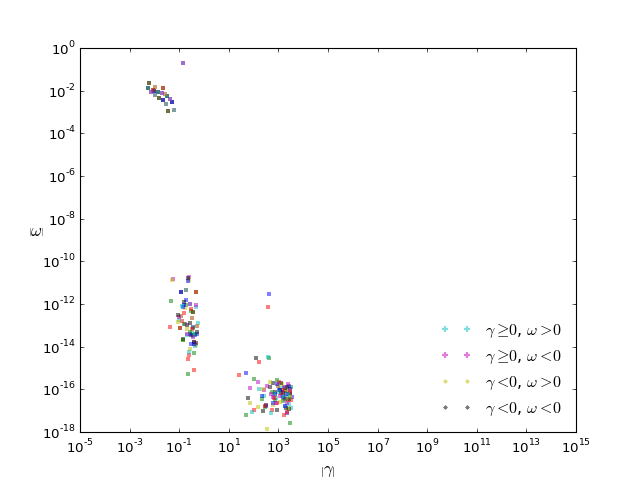

In [5]:
EPordere.spectrum(spectype = "good")

In [18]:
adjnew = de.EVP(d1,
         ['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

adjnew.parameters['Q'] = Q
adjnew.parameters['iR'] = iR
adjnew.parameters['iRm'] = iRm
adjnew.parameters['xi'] = xi
adjnew.parameters['beta'] = beta
adjnew.parameters['c1'] = c1
adjnew.parameters['c2'] = c2
adjnew.parameters['B0'] = 1
adjnew.parameters['dz'] = 1j*Q

if conducting is False:
    adjnew.parameters['bessel1'] = special.iv(0, Q*R1)/special.iv(1, Q*R1)
    adjnew.parameters['bessel2'] = special.kn(0, Q*R2)/special.kn(1, Q*R2)

adjnew.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
adjnew.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
adjnew.substitutions['twooverbeta'] = '(2.0/beta)'

# multiply by [r^4, r^2, r^3, r^2]
#adjnew.add_equation("sigma*(-r**3*Q**2*psi + r**3*psirr - r**2*psir) - Q**4*r**3*iR*psi + iR*2*Q**2*r**3*psirr - iR*2*Q**2*r**2*psir - 1j*Q*r*rrdu0*u + 1j*Q*r**4*A - 1j*Q*r*ru0*u + xi*2*1j*Q*r*B - iR*r**3*dr(psirrr) + iR*2*r**2*psirrr - iR*3*r*psirr + iR*3*psir = 0")
#adjnew.add_equation("sigma*r**2*u + Q**2*r**2*iR*u + 1j*Q*r**2*B + 2*1j*Q*ru0*psi - iR*r**2*dr(ur) + iR*r*ur = 0")
#adjnew.add_equation("sigma*r**3*A - twooverbeta*1j*Q**3*r**2*psi + iRm*Q**2*r**3*A + 1j*Q*rrdu0*B - 1j*Q*ru0*B + twooverbeta*1j*Q*r**2*psirr - twooverbeta*1j*Q*r*psir - iRm*r**3*dr(Ar) - iRm*r**2*Ar + iRm*r*A = 0")
#adjnew.add_equation("sigma*r**2*B + iRm*Q**2*r**2*B + twooverbeta*1j*Q*r**2*u - xi*twooverbeta*2*1j*Q*psi - iRm*r**2*dr(Br) + iRm*r*Br = 0") 

# multiplied by [r^5, r^2, r^3, r^2]
adjnew.add_equation("sigma*(-Q**2*r**4*psi + r**4*psirr + r**3*psir - r**2*psi) - iR*Q**4*r**4*psi + iR*2*Q**2*r**4*psirr + iR*2*Q**2*r**3*psir - iR*2*Q**2*r**2*psi - 1j*Q*rrdu0*r**2*u + 1j*Q*r**5*A - 1j*Q*r**2*ru0*u + xi*2*1j*Q*r**2*B - iR*r**4*dr(psirrr) - 2*iR*r**3*psirrr + iR*3*r**2*psirr - iR*3*r*psir + iR*3*psi = 0")
adjnew.add_equation("sigma*r**2*u + iR*Q**2*r**2*u + 1j*Q*r**2*B + 2*1j*Q*ru0*psi - iR*r**2*dr(ur) - iR*r*ur + iR*u = 0")
adjnew.add_equation("sigma*r**3*A - (2/beta)*1j*Q**3*r**2*psi + iRm*Q**2*r**3*A + 1j*Q*rrdu0*B - 1j*Q*ru0*B + (2/beta)*1j*Q*r**2*psirr + (2/beta)*1j*Q*r*psir - (2/beta)*1j*Q*psi - iRm*r**3*dr(Ar) - iRm*3*r**2*Ar = 0")
adjnew.add_equation("sigma*r**2*B + iRm*Q**2*r**2*B + (2/beta)*1j*Q*r**2*u - xi*(2/beta)*2*1j*Q*psi - iRm*r**2*dr(Br) - iRm*r*Br + iRm*B = 0")

adjnew.add_equation("dr(psi) - psir = 0")
adjnew.add_equation("dr(psir) - psirr = 0")
adjnew.add_equation("dr(psirr) - psirrr = 0")
adjnew.add_equation("dr(u) - ur = 0")
adjnew.add_equation("dr(A) - Ar = 0")
adjnew.add_equation("dr(B) - Br = 0")

adjnew.add_bc('left(u) = 0')
adjnew.add_bc('right(u) = 0')
adjnew.add_bc('left(psi) = 0')
adjnew.add_bc('right(psi) = 0')
adjnew.add_bc('left(psir) = 0')
adjnew.add_bc('right(psir) = 0')
if conducting is True:
    adjnew.add_bc('left(A) = 0')
    adjnew.add_bc('right(A) = 0')
    adjnew.add_bc('left(B + r*Br) = 0')
    adjnew.add_bc('right(B + r*Br) = 0')
    #adjnew.add_bc('left(Br) = 0')
    #adjnew.add_bc('right(Br) = 0')
else:
    adjnew.add_bc('left(-Q*bessel1*A + Ar + A/r) = 0')
    adjnew.add_bc('right(Q*bessel2*A + Ar + A/r) = 0')
    adjnew.add_bc('left(B) = 0')
    adjnew.add_bc('right(B) = 0')

EPadjnew = Eigenproblem(adjnew)

EPadjnew.solve()
EPadjnew.reject_spurious()
evals_newadj = EPadjnew.evalues_good

2016-08-18 19:49:21,126 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-08-18 19:51:49,917 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta
/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


Number of positive real parts 1


<IPython.core.display.Javascript object>


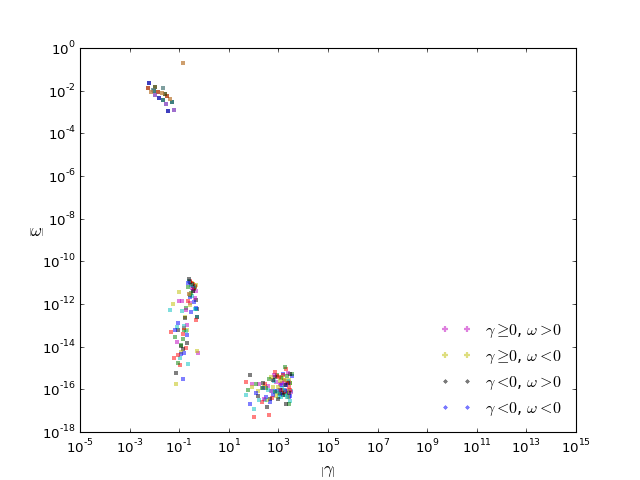

In [19]:
EPadjnew.spectrum(spectype = "good")

In [21]:
print(len(evals_newadj))
#print(len(evals_oldadj))
print(len(evals_ordere))

249
248


<IPython.core.display.Javascript object>


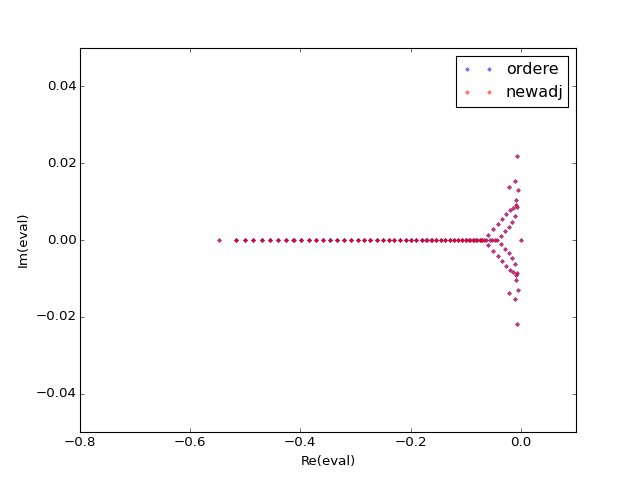

In [36]:
plt.figure()
plt.plot(evals_ordere.real, evals_ordere.imag, '.', alpha=0.5, label='ordere')
plt.plot(evals_newadj.real, -evals_newadj.imag, '.', alpha=0.5, label='newadj', color='red')
#plt.plot(evals_oldadj.real, -evals_oldadj.imag, '.', alpha=0.5, label='oldadj')
#plt.xlim(-.008, .001)
plt.ylim(-0.05, 0.05)
#plt.ylim(-0.1, 0.1)
plt.xlim(-0.8, 0.1)
plt.legend()
plt.xlabel("Re(eval)")
plt.ylabel("Im(eval)")

<IPython.core.display.Javascript object>


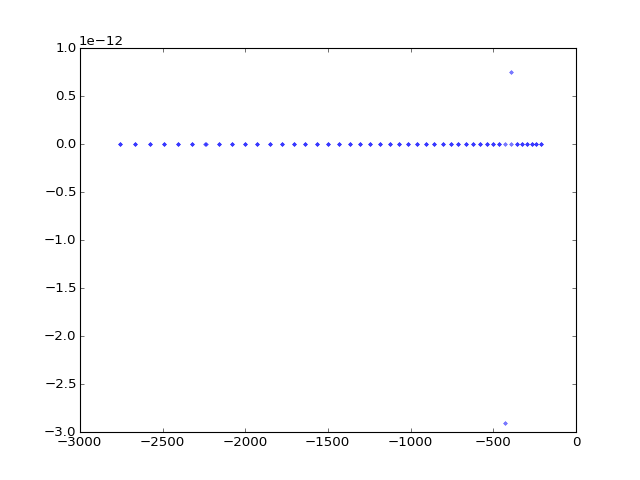

In [35]:
plt.figure()
plt.plot(evals_ordere[10:100].real, evals_ordere[10:100].imag + evals_newadj[10:100].imag, '.', alpha=0.5)
#plt.plot(evals_ordere[10:100].real, evals_ordere[10:100].imag - evals_newadj[10:100].imag, '.', alpha=0.5)

<IPython.core.display.Javascript object>


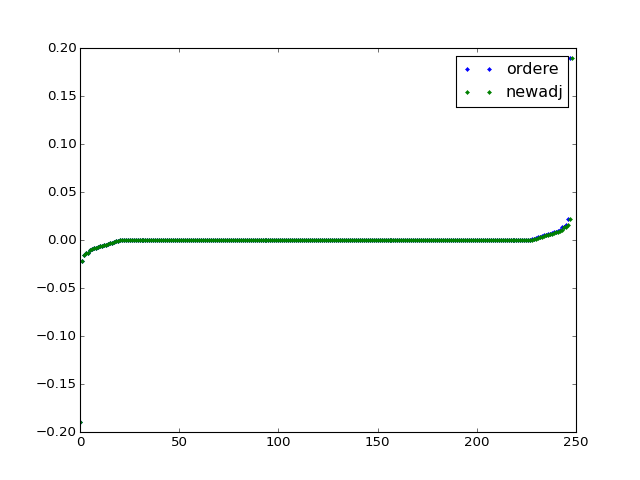

In [24]:
plt.figure()
plt.plot(np.sort(evals_ordere.imag), '.', label='ordere')
plt.plot(np.sort(-evals_newadj.imag), '.', label='newadj')
#plt.plot(np.sort(evals_oldadj.imag), '.', label='oldadj')
#plt.plot(evals_ordere.imag + evals_oldadj[2:].imag, '.')
plt.legend()

In [28]:
ordere_gr_rate = np.max(evals_ordere.real)
ordere_freq = evals_ordere[evals_ordere.real == ordere_gr_rate].imag
print(ordere_gr_rate, ordere_freq)

4.85901409036e-10 [  3.39717551e-14]


In [29]:
#oldadj_gr_rate = np.max(evals_oldadj.real)
#oldadj_freq = evals_oldadj[evals_oldadj.real == oldadj_gr_rate].imag
#print(oldadj_gr_rate, oldadj_freq)

In [30]:
newadj_gr_rate = np.max(evals_newadj.real)
newadj_freq = evals_newadj[evals_newadj.real == newadj_gr_rate].imag
print(newadj_gr_rate, newadj_freq)

4.85982729513e-10 [  6.26668113e-18]


In [31]:
gr, largest_eval_indx,freq  = EPadjnew.growth_rate({})
EPadjnew.solver.set_state(largest_eval_indx)

2016-08-19 00:32:49,766 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta
/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


<IPython.core.display.Javascript object>


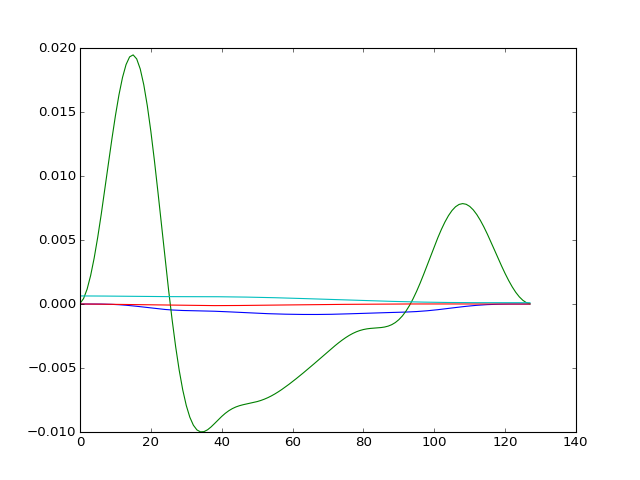

In [32]:
plt.figure()
plt.plot(EPadjnew.solver.state['psi']['g'].real)
plt.plot(EPadjnew.solver.state['u']['g'].real)
plt.plot(EPadjnew.solver.state['A']['g'].real)
plt.plot(EPadjnew.solver.state['B']['g'].real)

In [33]:
grordere, largest_eval_indx_ordere,freqordere  = EPordere.growth_rate({})
EPordere.solver.set_state(largest_eval_indx_ordere)

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


2016-08-19 00:45:50,863 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


<IPython.core.display.Javascript object>


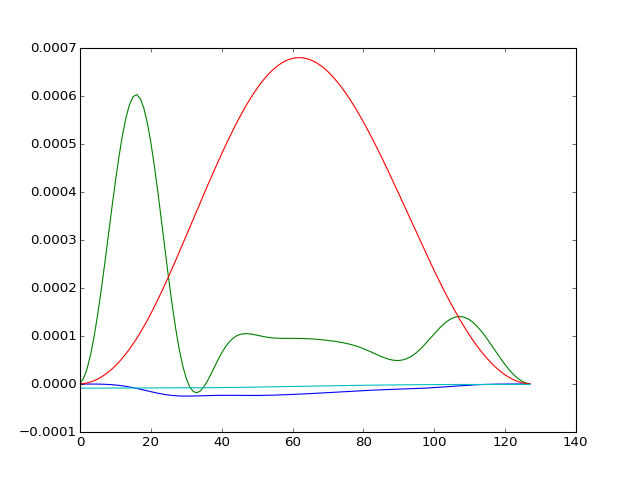

In [34]:
plt.figure()
plt.plot(EPordere.solver.state['psi']['g'].real)
plt.plot(EPordere.solver.state['u']['g'].real)
plt.plot(EPordere.solver.state['A']['g'].real)
plt.plot(EPordere.solver.state['B']['g'].real)

In [24]:
print(gr, grordere)
print(freq, freqordere)

-0.000276888046347 -0.000276888063939
[ -3.90461629e-13] [ -9.90155281e-14]


In [25]:
r = EPordere.solver.domain.grid(0)

invr = d1.new_field()
invr['g'] = (1/r)

def adjoint_inner_product(bra, ket, r, Q, keys=None):
    """assume bra, ket are dedalus state vectors; r is a string giving the
    coordinate to integrate over.
    
    computes 
    <bra|ket> = integral(bra* dot ket dr)
    """
    
    d = bra.domain.new_field()
    if not keys:
        keys = bra.state.field_dict.keys()
        
    for k in keys:
        if k == 'psi':
            #a_psi_rhs = invr*o1.psi_rr - invr**2*o1.psi_r - invr*self.Q**2*o1.psi
            d['g'] += bra.state[k]['g'].conj() * (invr['g']*ket.state['psirr']['g'] - invr['g']*Q**2 * ket.state[k]['g'] - invr['g']**2*ket.state['psir']['g'])
        else:
            d['g'] += bra.state[k]['g'].conj() * ket.state[k]['g']
    
    return d.integrate(r)['g'][0]


print("First, check fastest growing mode against adjoint")
ip = adjoint_inner_product(EPadjnew.solver,EPordere.solver,'r',Q,keys=['psi','u','A','B'])

print("Inner product = {}".format(ip))

print("Now, check another mode against adjoint")
mode2 = largest_eval_indx_ordere - 1
EPordere.solver.set_state(mode2)

ip2 = adjoint_inner_product(EPadjnew.solver,EPordere.solver,'r',Q, keys=['psi','u','A','B'])
print("ip2/ip = {}".format(ip2/ip))


First, check fastest growing mode against adjoint
Inner product = (-4.897924628396751e-10-1.233152534305381e-10j)
Now, check another mode against adjoint
ip2/ip = (7.34752906945412e-09-1.001205839136467e-09j)


In [26]:
ip2

(-3.7222283105032878e-18-4.1567933552786712e-19j)

In [27]:
print("Now, check yet another mode against adjoint")
mode3 = largest_eval_indx_ordere - 5
EPordere.solver.set_state(mode3)

ip2 = adjoint_inner_product(EPadjnew.solver,EPordere.solver,'r',Q, keys=['psi','u','A','B'])
print("ip2/ip = {}".format(ip2/ip))

print(ip2)

Now, check yet another mode against adjoint
ip2/ip = (1.6255769468490054e-08+6.142864070644683e-09j)
(-7.20444452366e-18-5.01331285377e-18j)


<IPython.core.display.Javascript object>


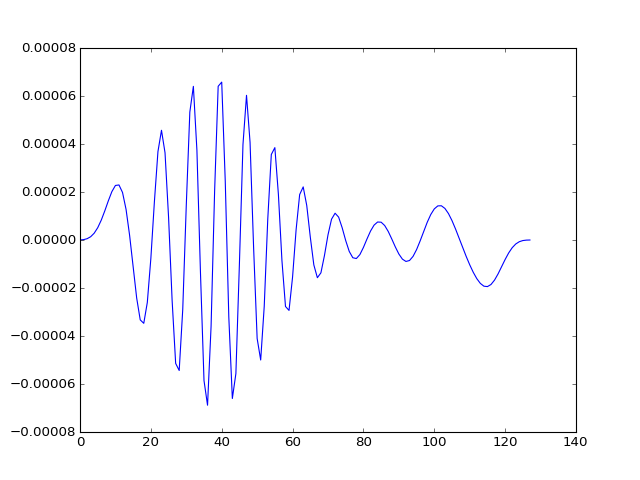

In [37]:
plt.figure()
plt.plot(EPordere.solver.state['u']['g'].real)